In [1]:
# ----------------------------------------Cell one---------------------------------------------------
import numpy as np
import random
from pettingzoo.utils.conversions import parallel_wrapper_fn
from gymnasium import spaces
from pettingzoo import ParallelEnv
import matplotlib.pyplot as plt
from tqdm import tqdm


In [59]:
# ----------------------------------------Cell two---------------------------------------------------
# ------------------------------- Class for Environmnet -------------------------------------------
# ---------------------------------------Start ----------------------------------------------------

class Environments(ParallelEnv):
    metadata = {'render.modes': ['human'], 'is_parallelizable': True, 'render_mode': 'human'}

    def __init__(self, env_type='basic'):
        super().__init__()
        self.env_type = env_type
        self.render_mode = 'human'
        self.init_environment()
        self.reset()

    def init_environment(self):
        if self.env_type == 'basic':
            self.init_basic_environment()
        elif self.env_type == 'extended':
            self.init_extended_environment()
        elif self.env_type == 'four_robot':
            self.init_four_robot_environment()


    def init_basic_environment(self):
        self.n_agents = 2
        self.n_actions = 4  # North, South, East, and West
        self.actions = {0:(1,0), 1:(-1, 0), 2:(0,1), 3:(0,-1)}
        self.grid_shape = (5, 5)
        self.max_cycles = 100
        self.agent_positions = [(0,0), (0,4)]
        self.doorways = [(2, 2)]
        self.goal_positions = [(4, 4), (4, 0)]
        self.mask = [(0, 2), (1, 2), (3,2), (4,2)]
        self.initial_agent_positions = [(0,0), (0,4)]
        self.init_common_environment()

    def init_extended_environment(self):
        self.n_agents = 2
        self.n_actions = 4
        self.grid_shape = (7, 7)
        self.max_cycles = 100
        self.agent_positions = [(0,1), (0,5)]
        self.doorways = [(3, 2), (2, 3), (3, 4), (4, 3)]
        self.goal_positions = [(6, 5), (6, 1)]
        self.mask = [(0, 0), (0, 6), (6,0), (6,6), (0, 3), (1, 3), (3,3), (5,3), (6, 3), (3, 0), (3,1), (3,5), (3,6)]
        self.initial_agent_positions = [(0,1), (0,5)]
        self.init_common_environment()

    def init_four_robot_environment(self):
        self.n_agents = 4
        self.n_actions = 4
        self.grid_shape = (7, 7)
        self.max_cycles = 100
        self.agent_positions = [(0,1), (0,5), (6,5), (6,1) ]
        self.doorways = [(2, 3), (3, 2), (3, 4), (4, 3)] # 4 doorways
        self.goal_positions = [(6, 5), (6, 1), (0, 1), (0, 5)]
        self.mask = [(0, 0), (0, 6), (6,0), (6,6), (0, 3), (1, 3), (3,3), (5,3), (6, 3), (3, 0), (3,1), (3,5), (3,6)]
        self.initial_agent_positions = [(0,1), (0,5), (6,5), (6,1) ]
        self.init_common_environment()

    def init_common_environment(self):
        self.doorway_penalty = -20
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Discrete(np.prod(self.grid_shape))
        self.agents = ["agent_{}".format(i) for i in range(self.n_agents)]
        # Mapping Agent Names to Indices
        self.agent_name_mapping = dict(zip(self.agents, list(range(len(self.agents)))))
        self.agent_pos = {agent: self.agent_positions[i] for i, agent in enumerate(self.agents)}
        # print("first print)")
        # print(self.agent_pos)
        self.agent_goals = {agent: self.goal_positions[i] for i, agent in enumerate(self.agents)}
        self.last_action = {agent: None for agent in self.agents}
        self.chose_coordinate_action = False
        self.chose_coordinate_actions = {agent: False for agent in self.agents}





    # Function to define each action
    def direction_offsets(self, action):
        # North, South, East, West
        return [(-1, 0), (1, 0), (0, 1), (0, -1)][action]



    def reset(self):
        # Initialize agent positions using self.agent_positions
        self.agent_pos = {agent: self.agent_positions[i] for i, agent in enumerate(self.agents)}

        # Initialize rewards, dones, and infos for each agent
        self.rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.goal_achieved = {agent: False for agent in self.agents}


        # Initialize the number of moves taken
        self.num_moves = 0

        # Calculate and return the initial state for each agent
        initial_states = {}
        for agent, pos in self.agent_pos.items():
            x, y = pos
            initial_state = x * self.grid_shape[1] + y
            initial_states[agent] = initial_state
        return initial_states
        # print("inside reset function")




    def step(self, actions):
        """Process actions for all agents and update the environment state simultaneously."""

        new_states = {}  # Initialize a dictionary to store new states for each agent
        agents_reached_goals = {}  # Dictionary to track positions of agents that reached their goals

        # Parallel update of agent positions
        for agent, action in actions.items():
            
            


            # Check if the agent has reached its goal
            if self.agent_pos[agent] == self.goal(agent):
                x, y = self.agent_pos[agent]
                new_state = x * self.grid_shape[1] + y
                new_states[agent] = new_state

            if not self.dones[agent]:
                # Apply the action to move the agent
                new_pos = self.apply_action(agent, action)

                # Calculate the new state
                x, y = new_pos
                new_state = x * self.grid_shape[1] + y
                new_states[agent] = new_state



        miscoordinated_agents = self.is_miscoordination()
        for agent in miscoordinated_agents:
            self.rewards[agent] -= 20  # Apply penalty
            


        
        # Parallel update of rewards, done status, and other infos
        for agent in self.agents:
            self.update_rewards_and_dones(agent)

        self.num_moves += 1

        # Check if the maximum number of cycles has been reached
        if self.num_moves >= self.max_cycles:
            for agent in self.agents:
                self.dones[agent] = True

        # Generate and return observations, rewards, dones for all agents
        observations = {agent: self.observe(agent) for agent in self.agents}
        # print("inside the step")
        # print(new_states, observations, self.rewards, self.dones, self.num_moves)
        return new_states, observations, self.rewards, self.dones, self.num_moves


    def update_rewards_and_dones(self, agent):
        action = self.last_action[agent]
        # Reward for reaching the goal
        
        if not self.dones[agent]:
            if self.agent_pos[agent] == self.goal(agent):
                self.rewards[agent] += 10
                self.dones[agent] = True
            else:
                self.rewards[agent] += 0


        return self.rewards[agent]
    
    
    
    def is_miscoordination(self):
        miscoordinated_agents = []
        for doorway in self.doorways:
            agents_in_doorway = [agent for agent, pos in self.agent_pos.items() if pos == doorway]
            if len(agents_in_doorway) > 1:
                miscoordinated_agents.extend(agents_in_doorway)
        return list(set(miscoordinated_agents))



    def apply_action(self, agent, action):
        self.last_action[agent] = action  # Store the last action

        dx, dy = self.direction_offsets(action)
        new_x, new_y = self.agent_pos[agent][0] + dx, self.agent_pos[agent][1] + dy

        # Check if new position is within bounds and not in a masked position
        if 0 <= new_x < self.grid_shape[0] and 0 <= new_y < self.grid_shape[1] and (new_x, new_y) not in self.mask:
            self.agent_pos[agent] = (new_x, new_y)

        return self.agent_pos[agent]

    def goal(self, agent):
        if self.env_type == 'basic' or self.env_type == 'extended':
            return (self.goal_positions[0]) if agent == "agent_0" else self.goal_positions[1]
        elif self.env_type == 'four_robot':
            goals = {
                "agent_0": self.goal_positions[0],
                "agent_1": self.goal_positions[1],
                "agent_2": self.goal_positions[2],
                "agent_3": self.goal_positions[3],
            }
            return goals[agent]



    def observe(self, agent):
        # Initialize a binary grid representation of the environment
        observation = np.zeros(np.prod(self.grid_shape), dtype=int)

        # Apply the mask
        for pos in self.mask:
            x, y = pos
            # Adjust for zero-based indexing
            index = (x) * self.grid_shape[1] + (y)
            if 0 <= index < np.prod(self.grid_shape):
                observation[index] = -50000

        # Mark the agent's own position
        # print(self.agent_pos[agent])
        own_pos = self.agent_pos[agent]
        observation[own_pos[0] * self.grid_shape[1] + own_pos[1]] = 5


        # Mark positions of other agents
        for other_agent, pos in self.agent_pos.items():
            if other_agent != agent:
                # print(other_agent, pos)
                observation[pos[0] * self.grid_shape[1] + pos[1]] = 2


        # Mark the doorways
        for doorway in self.doorways:
                observation[doorway[0] * self.grid_shape[1] + doorway[1]] = -10


        # Mark the goals
        for goal in self.goal_positions:
                observation[goal[0] * self.grid_shape[1] + goal[1]] = +10

        # print(observation)
        return observation




    def render(self, mode='human'):
        grid = [[' . ' for _ in range(self.grid_shape[1])] for _ in range(self.grid_shape[0])]

        # Mark the mask positions with 'M'
        for mask_pos in self.mask:
            x, y = mask_pos
            grid[x][y] = 'M'

        # Mark the doorways with 'D'
        for doorway in self.doorways:
            x, y = doorway
            if grid[x][y] == ' . ':
                grid[x][y] = 'D'

        # Mark goals with 'G'
        for i in(1,len(self.goal_positions)) :
            x, y = self.goal_positions[i-1]
            if grid[x][y] == ' . ':
                grid[x][y] = f'G{i-1}'

        # Mark agents
        for agent, pos in self.agent_pos.items():
            x, y = pos
            agent_idx = self.agent_name_mapping[agent]
            grid[x][y] = f'A{agent_idx}'

        cell_width = 3  # Define the width of each cell

        # Function to pad content in each cell to a fixed width
        def pad_content(content):
            return f"{content:^{cell_width}}"

        # Function to create a single row of the grid
        def create_row(row_data):
            padded_row = [pad_content(item) for item in row_data]
            return "|" + "|".join(padded_row) + "|"

        # Function to create a separator line
        def create_separator(width):
            return "+" + "+".join(["-" * cell_width for _ in range(width)]) + "+"

        # Print the top border
        print(create_separator(self.grid_shape[1]))

        # Print rows with separators
        for row in grid:
            print(create_row(row))
            print(create_separator(self.grid_shape[1]))

# ---------------------------------------Finish ---------------------------------------------------
# ------------------------------- Class for Environmnet -------------------------------------------



# ------------------------------- Printing the environmnet -------------------------------------------
# ---------------------------------------Start -------------------------------------------------------


env_type = 'basic'
environment = Environments(env_type=env_type)
environment.render()
initial_observations = {agent: environment.observe(agent) for agent in environment.agents}
print()
print()
print("Initial Observations:", initial_observations)
print()
print()



env_type = 'extended'
environment = Environments(env_type=env_type)
environment.render()
initial_observations = {agent: environment.observe(agent) for agent in environment.agents}
print()
print()
print("Initial Observations:", initial_observations)
print()
print()



env_type = 'four_robot'
environment = Environments(env_type=env_type)
environment.render()
initial_observations = {agent: environment.observe(agent) for agent in environment.agents}
print()
print()
print("Initial Observations:", initial_observations)
print()
print()


# ---------------------------------------Finish ---------------------------------------------------
# ------------------------------- Printing the environmnet -------------------------------------------

+---+---+---+---+---+
|A0 | . | M | . |A1 |
+---+---+---+---+---+
| . | . | M | . | . |
+---+---+---+---+---+
| . | . | D | . | . |
+---+---+---+---+---+
| . | . | M | . | . |
+---+---+---+---+---+
|G1 | . | M | . |G0 |
+---+---+---+---+---+


Initial Observations: {'agent_0': array([     5,      0, -50000,      0,      2,      0,      0, -50000,
            0,      0,      0,      0,    -10,      0,      0,      0,
            0, -50000,      0,      0,     10,      0, -50000,      0,
           10]), 'agent_1': array([     2,      0, -50000,      0,      5,      0,      0, -50000,
            0,      0,      0,      0,    -10,      0,      0,      0,
            0, -50000,      0,      0,     10,      0, -50000,      0,
           10])}


+---+---+---+---+---+---+---+
| M |A0 | . | M | . |A1 | M |
+---+---+---+---+---+---+---+
| . | . | . | M | . | . | . |
+---+---+---+---+---+---+---+
| . | . | . | D | . | . | . |
+---+---+---+---+---+---+---+
| M | M | D | M | D | M | M |
+---+---+

In [3]:
# ----------------------------------------Cell three---------------------------------------------------
# ------------------------------- Class for First algorithm -------------------------------------------
# ---------------------------------------Start -------------------------------------------------------


class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9999):
        self.n_states = n_states
        self.q_table = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.n_actions = n_actions

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)  # Explore: random action
        else:
            # Exploit: choose the best action based on Q-table
            return np.argmax(self.q_table[state])


    def update_q_table(self, state, action, reward, next_state, goal_achieved):
        #         print("state:", state)
        #         print("action:", action)
        #         print("reward:", reward)
        #         print("next_state:", next_state)
        #         print("done:", done)
        if not goal_achieved:
            best_next_action = np.argmax(self.q_table[next_state])
            td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
            td_error = td_target - self.q_table[state][action]
            self.q_table[state][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        
        
    def reset_epsilon(self):
        self.epsilon = 1.0  

# ---------------------------------------Finish ---------------------------------------------------
# ------------------------------- Class for First algorithm -------------------------------------------



# ------------------------------- Functions to Run First Algorithm  -------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

def run_episode(env, agents):
    observations = env.reset()
    done = {agent: False for agent in env.agents}
    total_rewards = {agent: 0 for agent in env.agents}
    # print(total_rewards)
    num_moves = 0
    miscoordination_count = 0

    while not all(done.values()):
        actions = {}
        for agent in env.agents:
            action = agents[agent].select_action(observations[agent])
            actions[agent] = action

        new_states, next_observations, rewards, done, moves = env.step(actions)
        # env.render()
        num_moves += 1
        miscoordinated_agents = env.is_miscoordination()
        if len(miscoordinated_agents) > 0:
            miscoordination_count += 1

        for agent in env.agents:
              # Accumulate rewards for each agent
            
            goal_achieved = env.goal_achieved[agent]
            agents[agent].update_q_table(observations[agent], actions[agent], rewards[agent], new_states[agent], goal_achieved)

            if env.agent_pos[agent] == env.goal(agent):
                env.goal_achieved[agent] = True

            miscoordinated_agents = env.is_miscoordination()
            miscoordination_message = "Yes" if agent in miscoordinated_agents else "No"
            # print(f"Agent: {agent}, Epsilon: {agents[agent].epsilon:.4f}, Reward: {rewards[agent]}, Miscoordination: {miscoordination_message}, Number of moves: {num_moves}")

        observations = new_states
    
    for agent in env.agents:
        agents[agent].decay_epsilon()
        total_rewards[agent] += rewards[agent]
    
    # Calculate the average reward per agent
    average_reward = sum(total_rewards.values()) / len(env.agents)
    return average_reward, num_moves, miscoordination_count




def evaluate_agent(env, agents, num_eval_episodes=32):
    original_epsilons = {agent: agents[agent].epsilon for agent in env.agents}
    for agent in agents.values():
        agent.epsilon = 0

    total_episode_rewards = []  # To store rewards for each evaluation episode
    total_episode_steps = []    # To store steps for each evaluation episode
    total_episode_miscoordinations = []  # To store miscoordination counts for each evaluation episode

    for _ in range(num_eval_episodes):  # Evaluate for 3 episodes
        observations = env.reset()
        done = {agent: False for agent in env.agents}
        total_rewards = {agent: 0 for agent in env.agents}
        num_moves = 0
        miscoordination_count = 0  # Initialize miscoordination count for the episode

        while not all(done.values()):
            actions = {}
            for agent in env.agents:
                action = agents[agent].select_action(observations[agent])
                actions[agent] = action

            new_states, next_observations, rewards, done, moves = env.step(actions)
            num_moves += 1

            miscoordinated_agents = env.is_miscoordination()
            if len(miscoordinated_agents) > 0:
                miscoordination_count += 1 

            observations = new_states
        for agent in env.agents:
            total_rewards[agent] += rewards[agent]
        average_reward = sum(total_rewards.values()) / len(env.agents)
        total_episode_rewards.append(average_reward)
        total_episode_steps.append(num_moves)
        total_episode_miscoordinations.append(miscoordination_count)  
        
    eval_avg_reward = sum(total_episode_rewards) / num_eval_episodes
    eval_avg_steps = sum(total_episode_steps) / num_eval_episodes
    eval_avg_miscoordinations = sum(total_episode_miscoordinations) / num_eval_episodes  

    # Restore original epsilon values
    for agent, epsilon in original_epsilons.items():
        agents[agent].epsilon = epsilon
    
    return eval_avg_reward, eval_avg_steps, eval_avg_miscoordinations


def run_simulation(num_runs, num_episodes, eval_interval, env_type):
    # Initialize the environment and agents
    env = Environments(env_type=env_type)

    n_states = np.prod(env.grid_shape)  # Number of states
    n_actions = env.n_actions  # Number of actions

    # Create agents
    agents = {agent: QLearningAgent(n_states, n_actions) for agent in env.agents}

    # Data structures to store results
    training_results = {'rewards': np.zeros((num_runs, num_episodes)),
                        'steps': np.zeros((num_runs, num_episodes)),
                        'miscoordinations': np.zeros((num_runs, num_episodes))}

    evaluation_results = {'rewards': np.zeros((num_runs, num_episodes // eval_interval)),
                          'steps': np.zeros((num_runs, num_episodes // eval_interval)),
                          'miscoordinations': np.zeros((num_runs, num_episodes // eval_interval))}


    for run in tqdm(range(num_runs), desc='Runs', position=0, ncols=100, mininterval=1):
        for agent in agents.values():
            agent.reset_epsilon()

        for episode in tqdm(range(num_episodes), desc='Episodes', position=1, leave=False, ncols=100, mininterval=30):
            # Run training episode
            avg_reward, steps, miscoord = run_episode(env, agents)

            # Store results
            training_results['rewards'][run, episode] = avg_reward
            training_results['steps'][run, episode] = steps
            training_results['miscoordinations'][run, episode] = miscoord

            # Evaluation
            if (episode + 1) % eval_interval == 0:
                eval_reward, eval_steps, eval_miscoord = evaluate_agent(env, agents, num_eval_episodes=32)

                eval_index = episode // eval_interval
                evaluation_results['rewards'][run, eval_index] = eval_reward
                evaluation_results['steps'][run, eval_index] = eval_steps
                evaluation_results['miscoordinations'][run, eval_index] = eval_miscoord

    return training_results, evaluation_results


# ---------------------------------------Finish ---------------------------------------------------
# ------------------------------- Functions to Run First Algorithm -------------------------------------------


def plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, env_type, algorithm):

    metrics = ['rewards', 'miscoordinations', 'steps']
    means_stds = {}
    for metric in metrics:
        means_stds[metric] = {
            'mean_train': np.mean(training_results[metric], axis=0),
            'std_train': np.std(training_results[metric], axis=0),
            'mean_eval': np.mean(evaluation_results[metric], axis=0),
            'std_eval': np.std(evaluation_results[metric], axis=0)
        }

    # Plotting
    plt.figure(figsize=(12, 18))
    titles = {
        'rewards': 'Rewards',
        'miscoordinations': 'Miscoordinations',
        'steps': 'Steps'
    }
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 1, i)
        plt.title(f'Training and Evaluation {titles[metric]} Over Episodes for {env_type} Environment and {algorithm}')
        plt.xlabel('Episode')
        plt.ylabel(titles[metric])
        plt.plot(x_episodes, means_stds[metric]['mean_train'], label=f'Mean Training {titles[metric]}')
        plt.fill_between(x_episodes, means_stds[metric]['mean_train'] - means_stds[metric]['std_train'],
                         means_stds[metric]['mean_train'] + means_stds[metric]['std_train'], alpha=0.2)
        plt.errorbar(x_eval_episodes, means_stds[metric]['mean_eval'], yerr=means_stds[metric]['std_eval'],
                     fmt='o', label=f'Evaluation {titles[metric]} (Scatter with Error Bars)')
        plt.legend()

    plt.tight_layout()
    plt.show()



# ---------------------------------------Finish -------------------------------------------------------
# ------------------------------- Functions to Run First Algorithm  -------------------------------------------



In [ ]:
# ----------------------------------------Cell four---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------
from tqdm import tqdm
num_runs = 7
num_episodes = 10000
eval_interval = 1000
env_type = "basic"

training_results, evaluation_results = run_simulation(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------



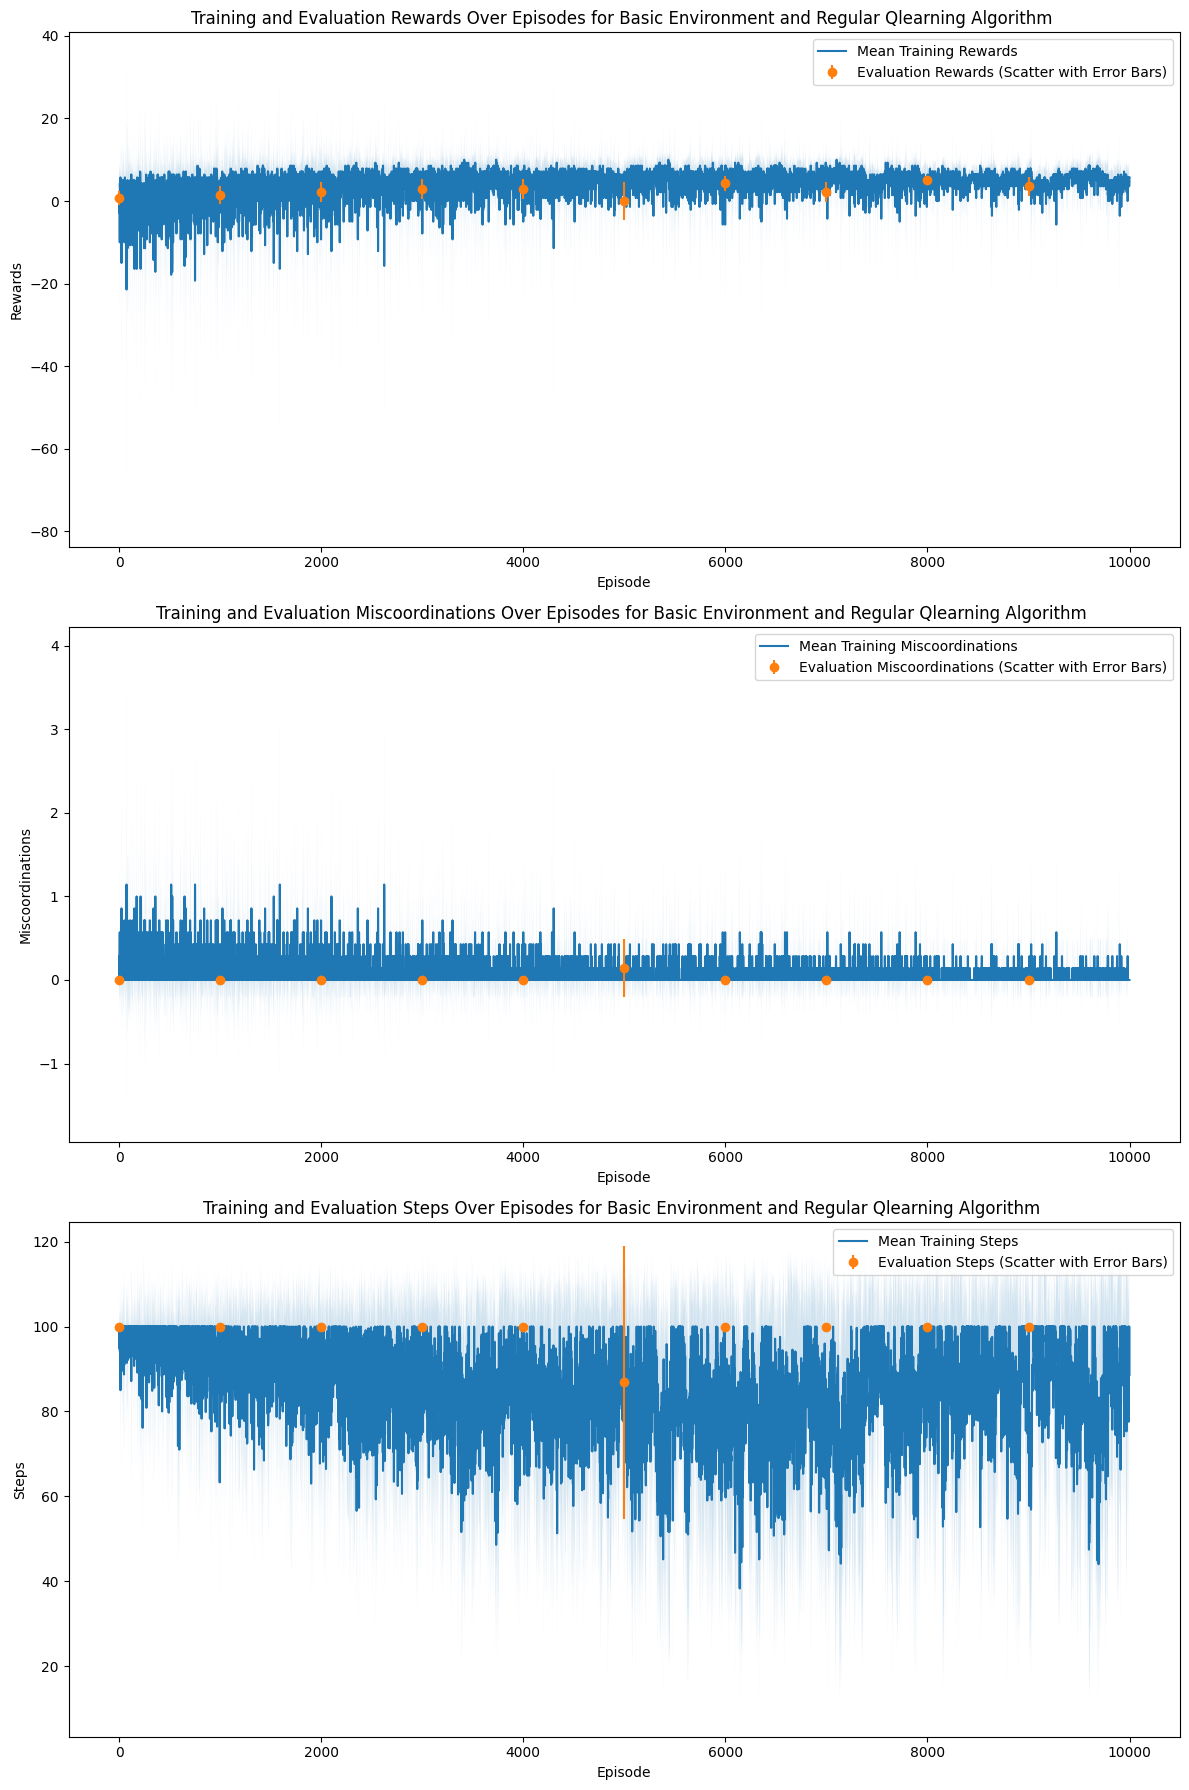

<Figure size 640x480 with 0 Axes>

In [27]:
# ----------------------------------------Cell five---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "Basic", "Regular Qlearning Algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [ ]:
# ----------------------------------------Cell Six---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

num_runs = 7
num_episodes = 10000
eval_interval = 1000
env_type = "extended"

training_results, evaluation_results = run_simulation(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------


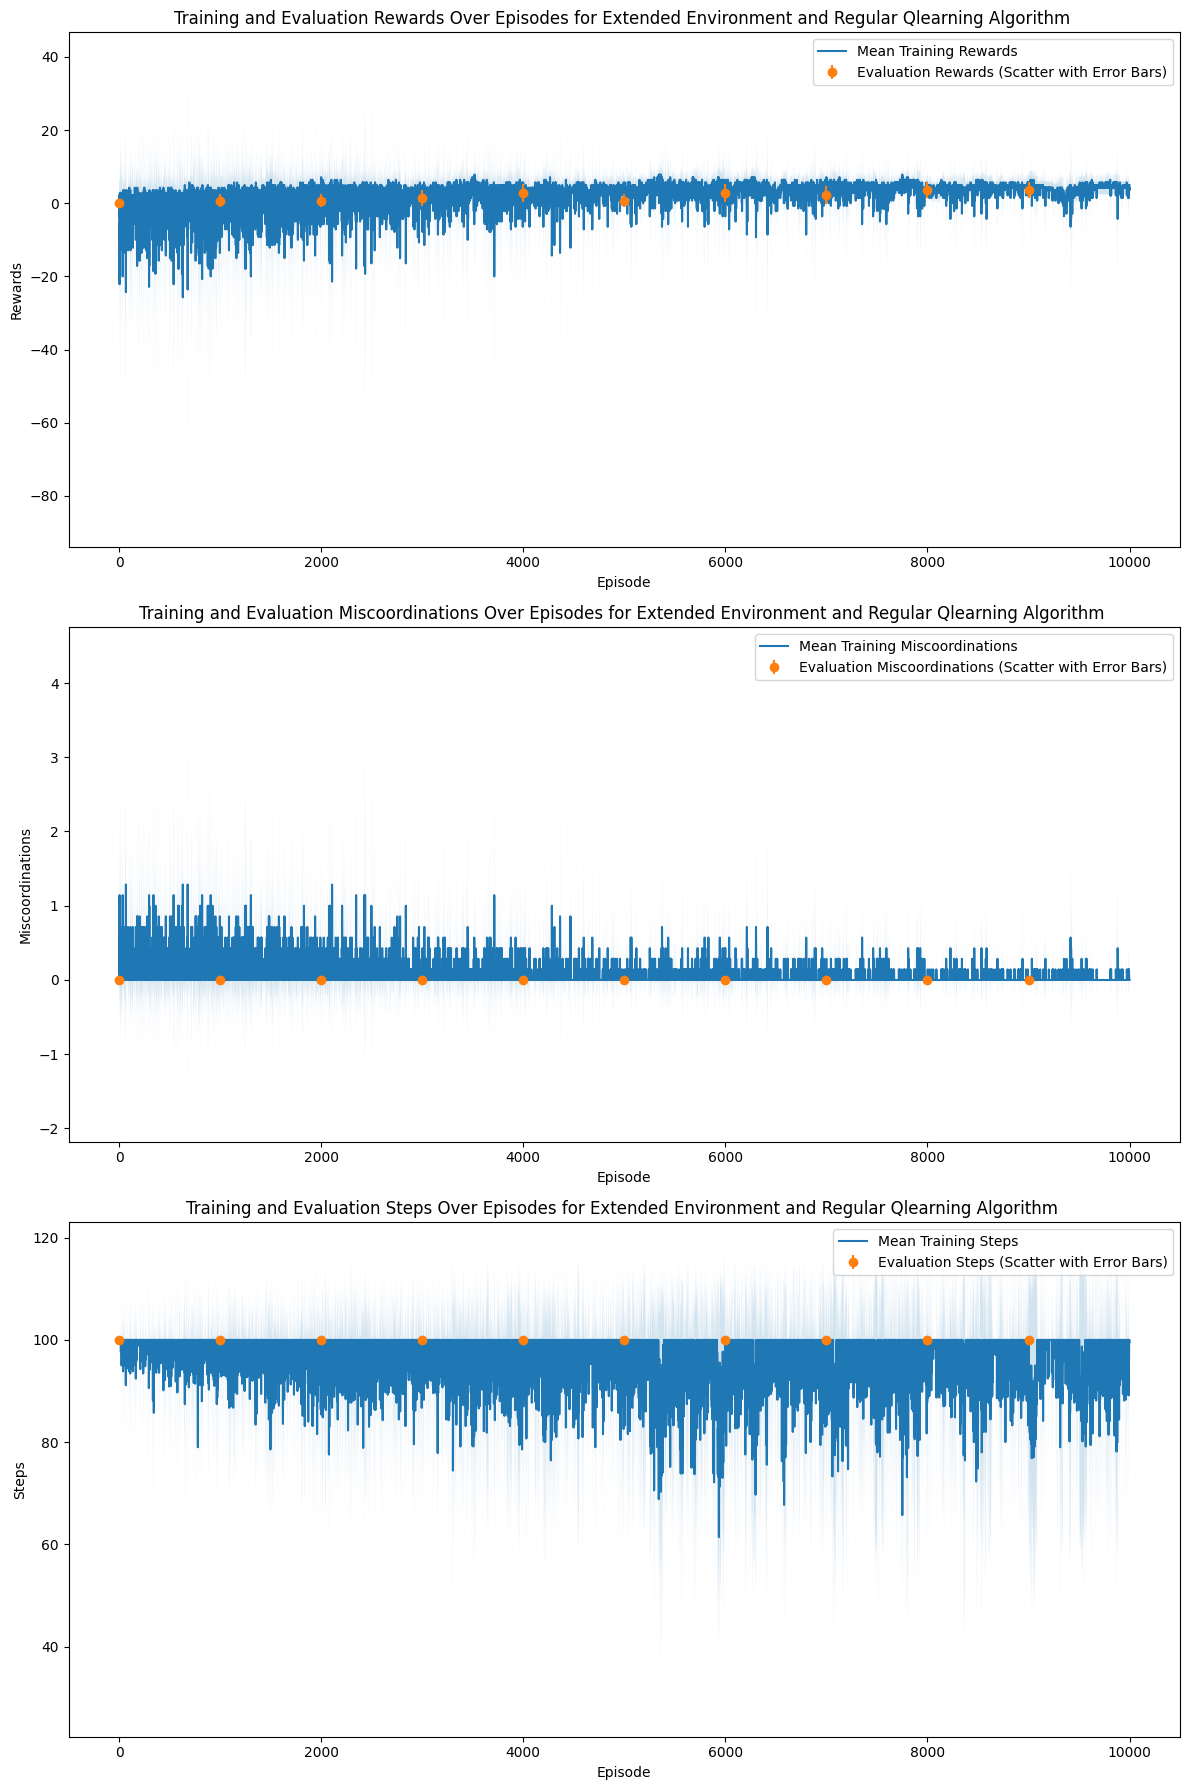

In [29]:
# -------------------------------------Cell Seven---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "Extended", "Regular Qlearning Algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [ ]:
# -------------------------------- -----Cell Eight---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

num_runs = 7
num_episodes = 10000
eval_interval = 1000
env_type = "four_robot"

training_results, evaluation_results = run_simulation(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------


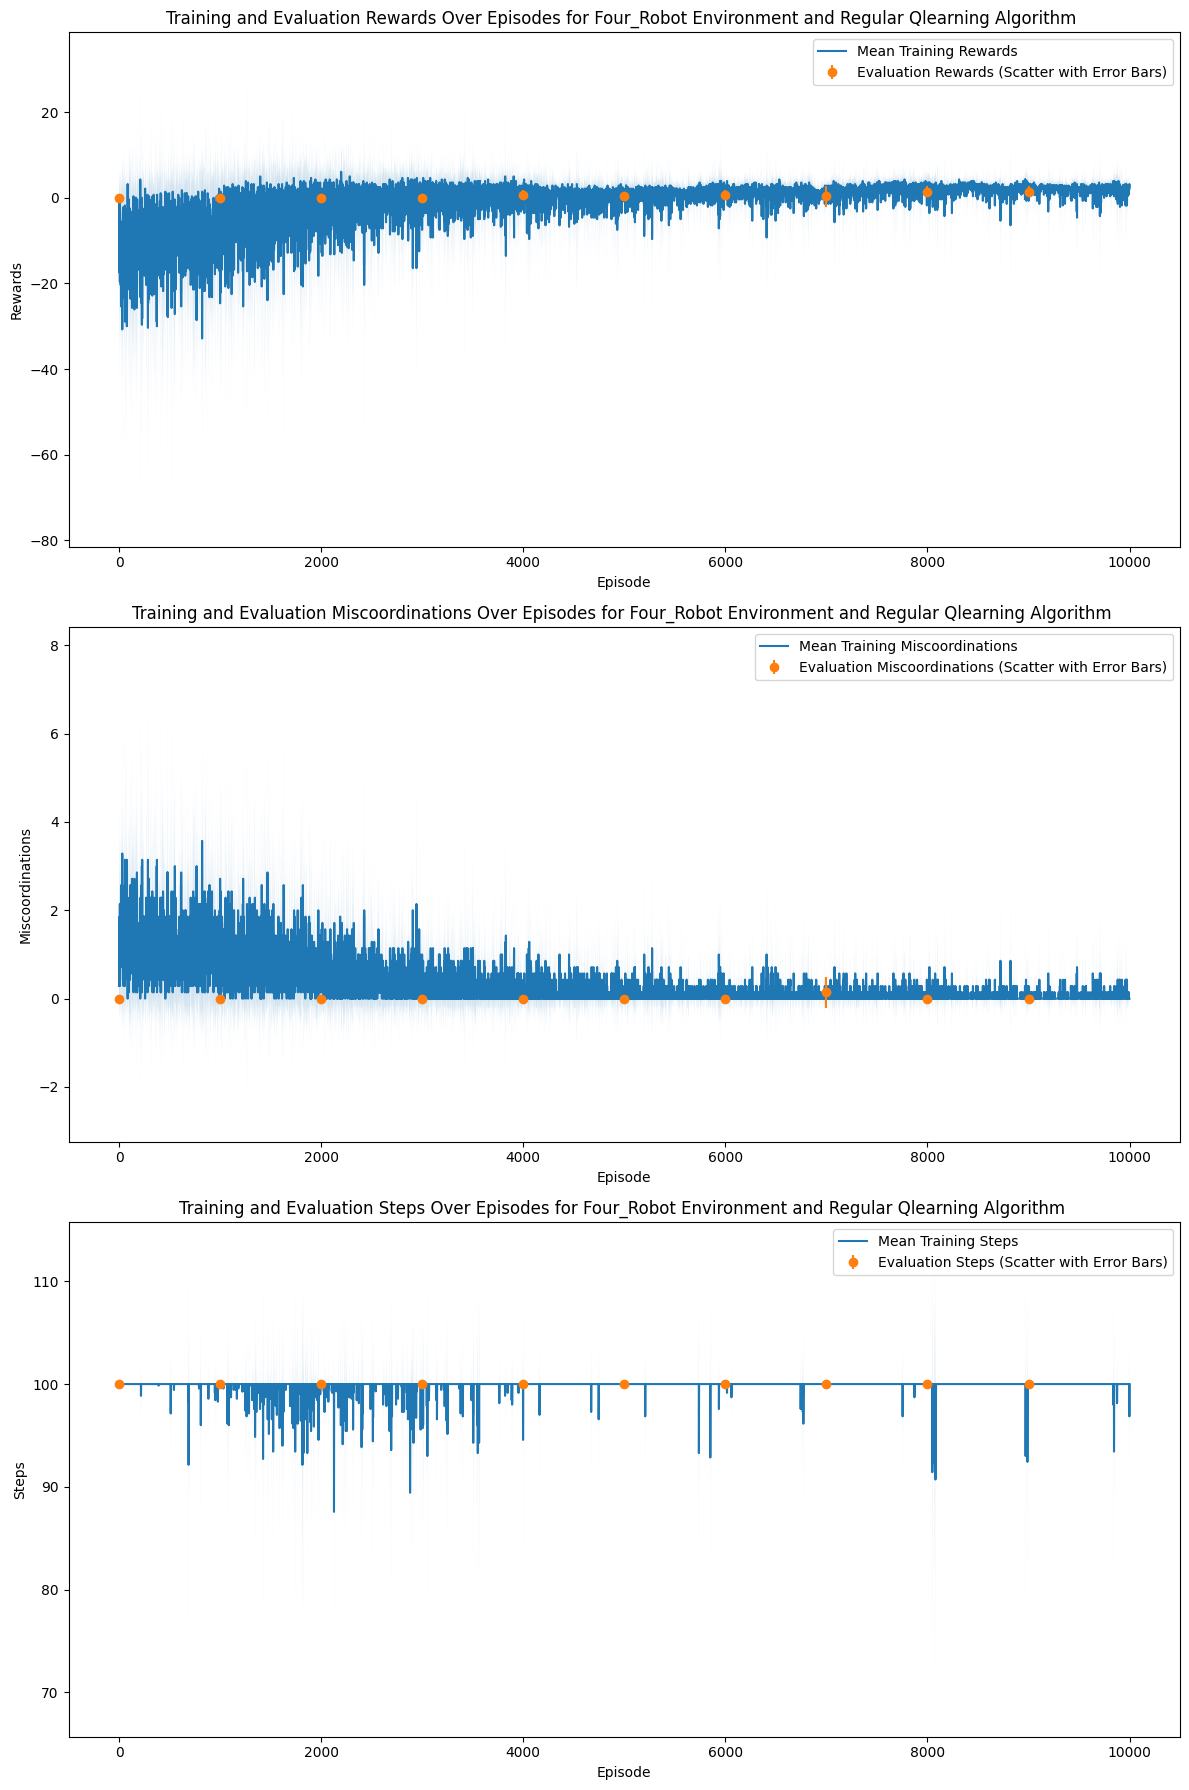

In [31]:
# --------------------------------------Cell Nine---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "Four_Robot", "Regular Qlearning Algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [60]:
# -------------------------------- -----Cell Ten---------------------------------------------------
# -----------------------sparse interaction algorithm - Environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

class ModifiedEnvironments(Environments):

    def init_environment(self):
        # Call the appropriate environment initialization method
        if self.env_type == 'basic':
            self.init_basic_environment()
        elif self.env_type == 'extended':
            self.init_extended_environment()
        elif self.env_type == 'four_robot':
            self.init_four_robot_environment()
        else:
            # Optionally handle unknown environment types
            raise ValueError(f"Unknown environment type: {self.env_type}")


    def init_basic_environment(self):
        super().init_basic_environment()
        self.n_agents = 2
        self.new_n_actions = 5  # North, South, East, West, coordination
        self.new_actions = {0:(1,0), 1:(-1, 0), 2:(0,1), 3:(0,-1), 4:(0,0)}
        # self.initial_agent_positions = [(0,0), (0,4)]

    def init_extended_environment(self):
        super().init_extended_environment()
        self.new_n_actions = 5  # North, South, East, West, coordination
        self.new_actions = {0:(1,0), 1:(-1, 0), 2:(0,1), 3:(0,-1), 4:(0,0)}
        # self.initial_agent_positions = [(0,1), (0,5), (6,5), (6,1) ]


    def init_four_robot_environment(self):
        super().init_four_robot_environment()
        self.new_n_actions = 5  # North, South, East, West, coordination
        self.new_actions = {0:(1,0), 1:(-1, 0), 2:(0,1), 3:(0,-1), 4:(0,0)}
        # self.initial_agent_positions = [(0,1), (0,5), (6,5), (6,1) ]


    def active_perception(self, agent):

        x, y = self.agent_pos[agent]
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            check_pos = (x + dx, y + dy)     
            if check_pos in self.agent_positions:
                return True  
        return False
    
    def reset(self):
        # Initialize agent positions using self.agent_positions
        self.agent_pos = {agent: self.initial_agent_positions[i] for i, agent in enumerate(self.agents)}
        

        # Initialize rewards, dones, and infos for each agent
        self.rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.goal_achieved = {agent: False for agent in self.agents}


        # Initialize the number of moves taken
        self.num_moves = 0

        # Calculate and return the initial state for each agent
        initial_states = {}
        for agent, pos in self.agent_pos.items():
            x, y = pos
            initial_state = x * self.grid_shape[1] + y
            initial_states[agent] = initial_state
        return initial_states
        # print("inside reset function")    
    
    
    def update_rewards_and_dones(self, agent):
        action = self.last_action[agent]
        # Reward for reaching the goal
        if not self.dones[agent]:
            if self.agent_pos[agent] == self.goal(agent):
                self.rewards[agent] += 10
                self.dones[agent] = True
            elif agents[agent].flag_reward:
                self.rewards[agent] += -1
                agents[agent].flag_reward = False
            else:
                self.rewards[agent] += 0
        return self.rewards[agent]
               
    
    def apply_action(self, agent, action):

        current_position = self.agent_pos[agent]
        if action == 4:  
            new_position = current_position
        else:
            new_position = super().apply_action(agent, action)
        return new_position

    def step(self, actions):
        new_states = {}  
        agents_reached_goals = {}  

        for agent, action in actions.items():
            if self.agent_pos[agent] == self.goal(agent):
                x, y = self.agent_pos[agent]
                new_state = x * self.grid_shape[1] + y
                new_states[agent] = new_state

            if not self.dones[agent]:
                new_pos = self.apply_action(agent, action)
                x, y = new_pos
                new_state = x * self.grid_shape[1] + y
                new_states[agent] = new_state

        miscoordinated_agents = self.is_miscoordination()
        for agent in miscoordinated_agents:
            self.rewards[agent] -= 20  # Apply penalty
            

        for agent in env.agents:
            ...
            env.update_rewards_and_dones(agent) 
            ...

        self.num_moves += 1

        if self.num_moves >= self.max_cycles:
            for agent in self.agents:
                self.dones[agent] = True

        observations = {agent: self.observe(agent) for agent in self.agents}
        return new_states, observations, self.rewards, self.dones, self.num_moves        
        
    def get_state_index(self, state):
        x, y = state
        return x * self.grid_shape[1] + y                 


# ---------------------------------------Finish -------------------------------------------------------
# -----------------------sparse interaction algorithm - Environment ---------------------------------



In [73]:
# -------------------------------- -----Cell 11---------------------------------------------------
# -----------------------------sparse interaction algorithm  ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

class SparseInteractionLearningAgent(QLearningAgent):
    def __init__(self, n_states, n_actions, new_n_actions, alpha=0.1, gamma=0.99, epsilon=1.0, 
                 epsilon_min=0.1, epsilon_decay=0.9999):
        super().__init__(n_states, new_n_actions, alpha, gamma, epsilon, 
                         epsilon_min, epsilon_decay)
        self.new_n_actions = new_n_actions  # Store new_n_actions as an attribute
        self.qc_table = np.zeros((n_states, new_n_actions))
        self.q_table = np.zeros((n_states, new_n_actions))
        self.flag_reward = False
        self.chose_coordinate_actions = False
#         self.chose_coordinate_actions = {agent: None for agent in agents}

        


    def select_action(self, state, active_percept):
        if np.random.rand() < self.epsilon:
            action =  np.random.randint(self.new_n_actions)

            if action == 4:
                self.flag_reward = True
                self.chose_coordinate_actions[agent] = True
                return np.random.randint(self.n_actions-1) 
            return action
        else:
            action = np.argmax(self.q_table[state])
            if action == 4:
                self.flag_reward = True
                self.chose_coordinate_actions[agent] = True
                if active_percept:
                    return np.argmax(self.qc_table[state])
                else:
                    return np.argmax(self.q_table[state]) 
            else:
                return np.argmax(self.q_table[state])
            
            

    def update_q_table(self, q_table, state, action, reward, next_state, goal_achieved):

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + self.gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += self.alpha * td_error
        
# ---------------------------------------Finish -----------------------------------------------------------
# -----------------------------sparse interaction algorithm  ----------------------------------------------



# ----------------------- Running of sparse interaction algorithm on two episode  ---------------------------------
# ---------------------------------------Start -------------------------------------------------------



# Initialize the environment and agents
env = ModifiedEnvironments(env_type='four_robot')
n_states = np.prod(env.grid_shape)  # Number of states
n_actions = env.n_actions  # Number of actions
new_n_actions = env.new_n_actions
agents = {agent: SparseInteractionLearningAgent(n_states, n_actions, new_n_actions) for agent in env.agents}
num_episodes = 2
# num_runs = 5


for episode in range(num_episodes):
    print(f"Episode {episode + 1}")
    observations = env.reset()  # Reset the environment and get initial observations
    env.render()
    total_miscoordinations = 0
    done = {agent: False for agent in env.agents}
    for agent in agents:
        agents[agent].chose_coordinate_actions = {other_agent: None for other_agent in agents}


    while not all(done.values()):
        flag_reward = False
        actions = {}
        for agent in env.agents:

            active_percept = env.active_perception(agent)
#             print("active percept", active_percept)
            action = agents[agent].select_action(observations[agent], active_percept)

            actions[agent] = action


        new_states, next_observations, rewards, done, num_moves = env.step(actions)
        env.render()
        miscoordinated_agents = env.is_miscoordination()
        if miscoordinated_agents:  # If there's any miscoordination in this step
            total_miscoordinations += 1  # Increment the counter

        # Update the Q-table for each agent
        for agent in env.agents:
            goal_achieved = env.goal_achieved[agent]
            agent_object = agents[agent]  # Get the agent object from the agents dictionary

            if agents[agent].chose_coordinate_actions[agent] and active_percept:
                agent_object.update_q_table(agent_object.qc_table,observations[agent], actions[agent], rewards[agent], new_states[agent], goal_achieved)
                agents[agent].chose_coordinate_actions[agent] = False
            else:
                agent_object.update_q_table(agent_object.q_table,observations[agent], actions[agent], rewards[agent], new_states[agent], goal_achieved)

            if env.agent_pos[agent] == env.goal(agent):
                env.goal_achieved[agent] = True

            miscoordination_message = "Yes" if agent in miscoordinated_agents else "No"
            print(f"Agent: {agent}, Epsilon: {agents[agent].epsilon:.4f}, Reward: {rewards[agent]}, Miscoordination: {miscoordination_message}, Number of moves: {num_moves}, Number of miscoor: {total_miscoordinations}")

        observations = new_states  # Update observations for the next iteration    
        print("______________________________________________________________________________________________________________________")
        

    # Decay epsilon for all agents
    for agent in env.agents:
        agents[agent].decay_epsilon()


#     # Print Q-tables at the end of the episode
#     for agent in env.agents:
#         print(f"Q-table for {agent} at the end of episode {episode + 1}:")
#         print(agents[agent].q_table)
#         print(f"QC-table for {agent} at the end of episode {episode + 1}:")
#         print(agents[agent].qc_table)


# ---------------------------------------Finish -------------------------------------------------------
# ----------------------- Functions to Run sparse interaction algorithm  ---------------------------------


Episode 1
+---+---+---+---+---+---+---+
| M |A0 | . | M | . |A1 | M |
+---+---+---+---+---+---+---+
| . | . | . | M | . | . | . |
+---+---+---+---+---+---+---+
| . | . | . | D | . | . | . |
+---+---+---+---+---+---+---+
| M | M | D | M | D | M | M |
+---+---+---+---+---+---+---+
| . | . | . | D | . | . | . |
+---+---+---+---+---+---+---+
| . | . | . | M | . | . | . |
+---+---+---+---+---+---+---+
| M |A3 | . | M | . |A2 | M |
+---+---+---+---+---+---+---+
+---+---+---+---+---+---+---+
| M | . |A0 | M |A1 |G3 | M |
+---+---+---+---+---+---+---+
| . | . | . | M | . | . | . |
+---+---+---+---+---+---+---+
| . | . | . | D | . | . | . |
+---+---+---+---+---+---+---+
| M | M | D | M | D | M | M |
+---+---+---+---+---+---+---+
| . | . | . | D | . | . | . |
+---+---+---+---+---+---+---+
| . | . | . | M | . | . | . |
+---+---+---+---+---+---+---+
| M | . |A3 | M | . |A2 | M |
+---+---+---+---+---+---+---+
Agent: agent_0, Epsilon: 1.0000, Reward: 0, Miscoordination: No, Number of moves: 1, Numbe

In [ ]:
# -------------------------------- -----Cell 12---------------------------------------------------
# -----------------------------Functions to Run sparse interaction algorithm ---------------------------------
# ---------------------------------------Start -------------------------------------------------------



def run_episode2(env, agents):
    observations = env.reset()
    done = {agent: False for agent in env.agents}
    total_rewards = {agent: 0 for agent in env.agents}
    # print(total_rewards)
    num_moves = 0
    miscoordination_count = 0
    for agent in agents:
        agents[agent].chose_coordinate_actions = {other_agent: None for other_agent in agents}
    while not all(done.values()):
        flag_reward = False
        actions = {}
        for agent in env.agents:
            active_percept = env.active_perception(agent)
            action = agents[agent].select_action(observations[agent], active_percept)
            actions[agent] = action
        new_states, next_observations, rewards, done, num_moves = env.step(actions)
        # env.render()
        num_moves += 1
        miscoordinated_agents = env.is_miscoordination()
        if len(miscoordinated_agents) > 0:
            miscoordination_count += 1

        for agent in env.agents:
            agent_object = agents[agent]  
            if agents[agent].chose_coordinate_actions[agent] and active_percept:
                agent_object.update_q_table(agent_object.qc_table,observations[agent], actions[agent], rewards[agent], new_states[agent], goal_achieved)
                agents[agent].chose_coordinate_actions[agent] = False
            else:
                agent_object.update_q_table(agent_object.q_table,observations[agent], actions[agent], rewards[agent], new_states[agent], goal_achieved)

            if env.agent_pos[agent] == env.goal(agent):
                env.goal_achieved[agent] = True

            miscoordinated_agents = env.is_miscoordination()

            # print(f"Agent: {agent}, Epsilon: {agents[agent].epsilon:.4f}, Reward: {rewards[agent]}, Miscoordination: {miscoordination_message}, Number of moves: {num_moves}")

        observations = new_states
    for agent in env.agents:
        agents[agent].decay_epsilon()
        total_rewards[agent] += rewards[agent]
    
    # Calculate the average reward per agent
    average_reward = sum(total_rewards.values()) / len(env.agents)
    return average_reward, num_moves-1, miscoordination_count




def evaluate_agent2(env, agents, num_eval_episodes=32):
    original_epsilons = {agent: agents[agent].epsilon for agent in env.agents}
    for agent in agents.values():
        agent.epsilon = 0

    total_episode_rewards = []  # To store rewards for each evaluation episode
    total_episode_steps = []    # To store steps for each evaluation episode
    total_episode_miscoordinations = []  # To store miscoordination counts for each evaluation episode

    for _ in range(num_eval_episodes):  # Evaluate for 3 episodes
        observations = env.reset()
        done = {agent: False for agent in env.agents}
        total_rewards = {agent: 0 for agent in env.agents}
        num_moves = 0
        miscoordination_count = 0  # Initialize miscoordination count for the episode

        while not all(done.values()):
            flag_reward = False
            actions = {}
            for agent in env.agents:
                active_percept = env.active_perception(agent)
                action = agents[agent].select_action(observations[agent], active_percept)
                actions[agent] = action
            new_states, next_observations, rewards, done, num_moves = env.step(actions)
            # env.render()
            num_moves += 1
            miscoordinated_agents = env.is_miscoordination()
            if len(miscoordinated_agents) > 0:
                miscoordination_count += 1

            observations = new_states
        for agent in env.agents:
            total_rewards[agent] += rewards[agent]
        average_reward = sum(total_rewards.values()) / len(env.agents)
        total_episode_rewards.append(average_reward)
        total_episode_steps.append(num_moves-1)
        total_episode_miscoordinations.append(miscoordination_count)  # Store miscoordination count for the episode

    eval_avg_reward = sum(total_episode_rewards) / num_eval_episodes
    eval_avg_steps = sum(total_episode_steps) / num_eval_episodes
    eval_avg_miscoordinations = sum(total_episode_miscoordinations) / num_eval_episodes  # Average miscoordination count

    # Restore original epsilon values
    for agent, epsilon in original_epsilons.items():
        agents[agent].epsilon = epsilon
    
    return eval_avg_reward, eval_avg_steps, eval_avg_miscoordinations



def run_simulation2(num_runs, num_episodes, eval_interval, env_type):
    # Initialize the environment and agents
    env = ModifiedEnvironments(env_type=env_type)

    n_states = np.prod(env.grid_shape)  # Number of states
    n_actions = env.n_actions  # Number of actions
    new_n_actions = env.new_n_actions

    # Create agents
    agents = {agent: SparseInteractionLearningAgent(n_states, n_actions, new_n_actions) for agent in env.agents}

    # Data structures to store results
    training_results = {'rewards': np.zeros((num_runs, num_episodes)),
                        'steps': np.zeros((num_runs, num_episodes)),
                        'miscoordinations': np.zeros((num_runs, num_episodes))}

    evaluation_results = {'rewards': np.zeros((num_runs, num_episodes // eval_interval)),
                          'steps': np.zeros((num_runs, num_episodes // eval_interval)),
                          'miscoordinations': np.zeros((num_runs, num_episodes // eval_interval))}


    for run in tqdm(range(num_runs), desc='Runs', position=0, ncols=100, mininterval=1):
        for agent in agents.values():
            agent.reset_epsilon()

        for episode in tqdm(range(num_episodes), desc='Episodes', position=1, leave=False, ncols=100, mininterval=10):
            # Run training episode
            avg_reward, steps, miscoord = run_episode2(env, agents)

            # Store results
            training_results['rewards'][run, episode] = avg_reward
            training_results['steps'][run, episode] = steps
            training_results['miscoordinations'][run, episode] = miscoord

            # Evaluation
            if (episode + 1) % eval_interval == 0:
                eval_reward, eval_steps, eval_miscoord = evaluate_agent2(env, agents, num_eval_episodes=32)

                eval_index = episode // eval_interval
                evaluation_results['rewards'][run, eval_index] = eval_reward
                evaluation_results['steps'][run, eval_index] = eval_steps
                evaluation_results['miscoordinations'][run, eval_index] = eval_miscoord

    return training_results, evaluation_results



def plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, env_type, algorithm):

    metrics = ['rewards', 'miscoordinations', 'steps']
    means_stds = {}
    for metric in metrics:
        means_stds[metric] = {
            'mean_train': np.mean(training_results[metric], axis=0),
            'std_train': np.std(training_results[metric], axis=0),
            'mean_eval': np.mean(evaluation_results[metric], axis=0),
            'std_eval': np.std(evaluation_results[metric], axis=0)
        }

    # Plotting
    plt.figure(figsize=(12, 18))
    titles = {
        'rewards': 'Rewards',
        'miscoordinations': 'Miscoordinations',
        'steps': 'Steps'
    }
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 1, i)
        plt.title(f'Training and Evaluation {titles[metric]} Over Episodes for {env_type} Environment and {algorithm}')
        plt.xlabel('Episode')
        plt.ylabel(titles[metric])
        plt.plot(x_episodes, means_stds[metric]['mean_train'], label=f'Mean Training {titles[metric]}')
        plt.fill_between(x_episodes, means_stds[metric]['mean_train'] - means_stds[metric]['std_train'],
                         means_stds[metric]['mean_train'] + means_stds[metric]['std_train'], alpha=0.2)
        plt.errorbar(x_eval_episodes, means_stds[metric]['mean_eval'], yerr=means_stds[metric]['std_eval'],
                     fmt='o', label=f'Evaluation {titles[metric]} (Scatter with Error Bars)')
        plt.legend()

    plt.tight_layout()
    plt.show()


# -----------------------------Functions to Run sparse interaction algorithm ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [74]:
# -------------------------------- -----Cell 13---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

num_runs = 7
num_episodes = 10000
eval_interval = 1000
env_type = "basic"

training_results, evaluation_results = run_simulation2(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------

Runs: 100%|██████████████████████████████████████████████████████████| 7/7 [24:32<00:00, 210.37s/it]


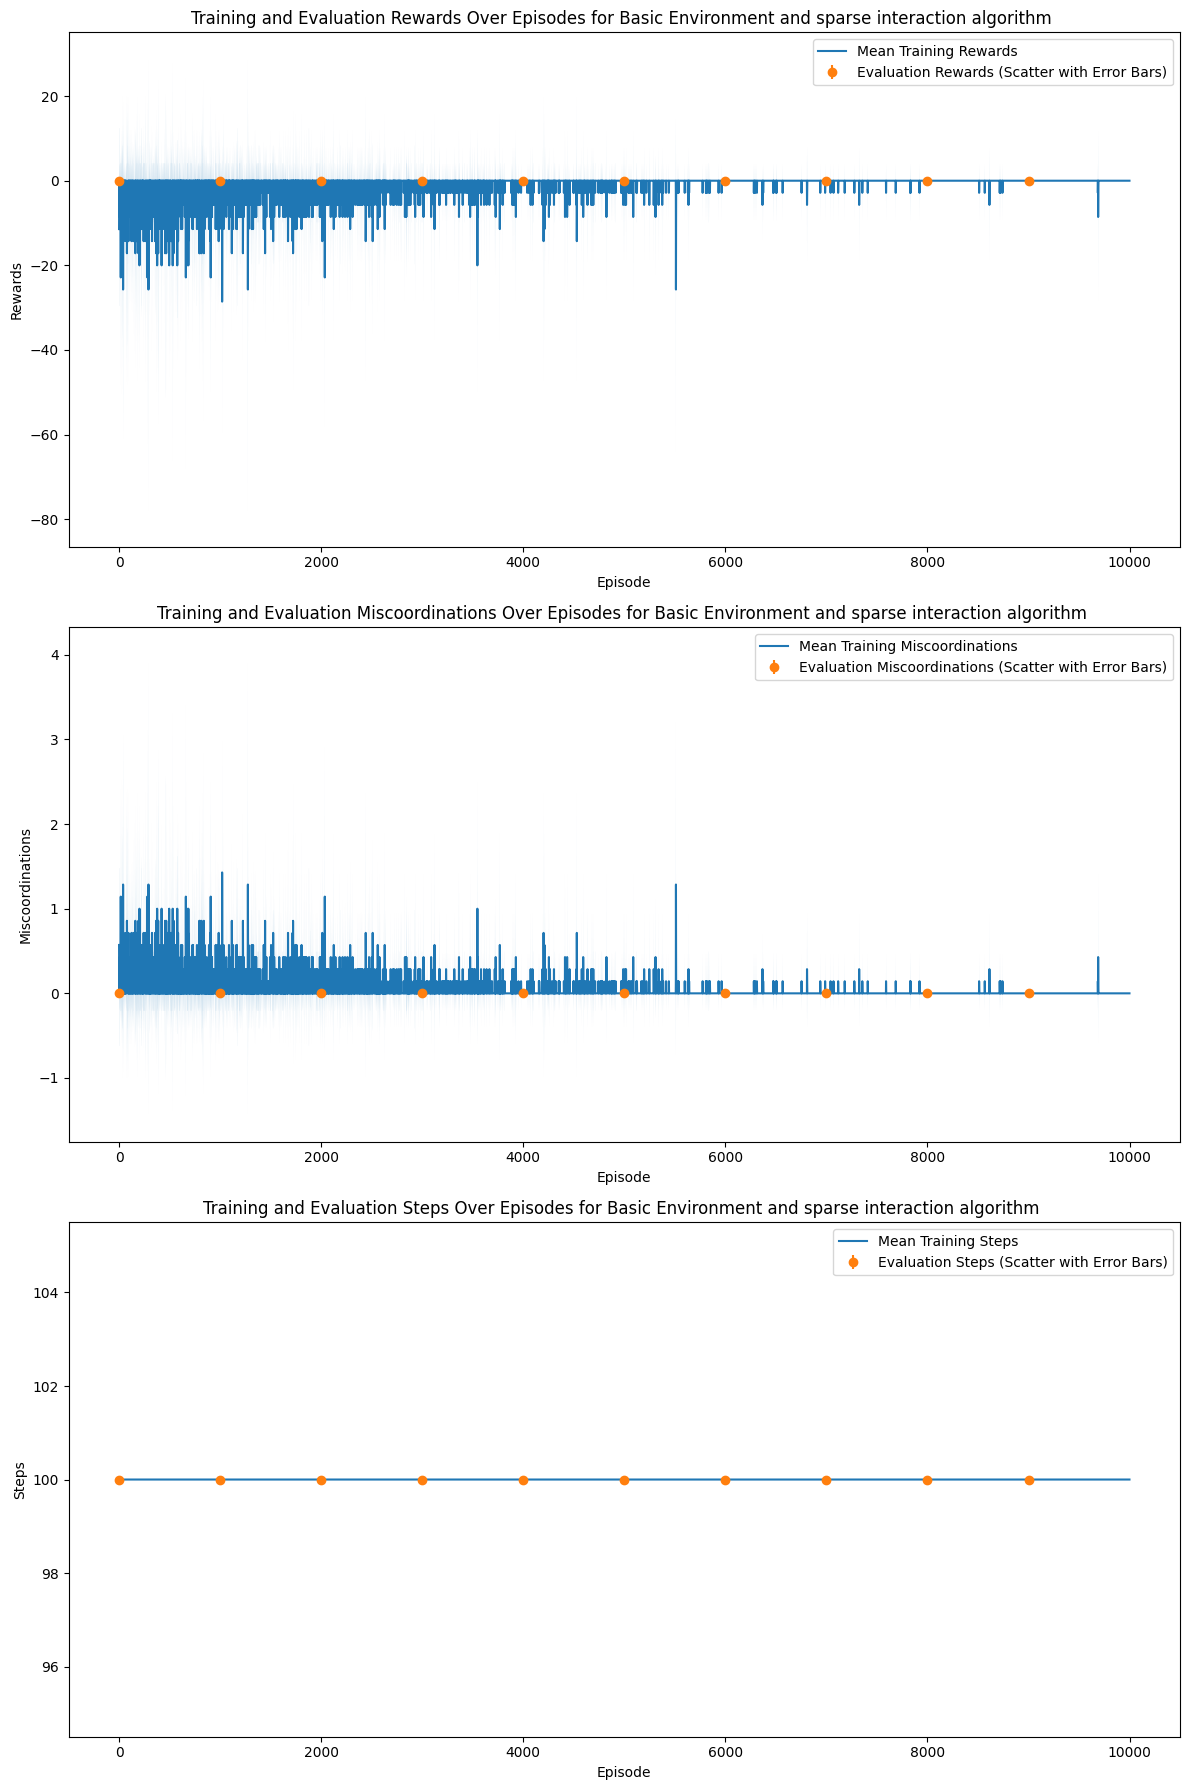

In [75]:
# --------------------------------------Cell 14---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "Basic", "sparse interaction algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [65]:
# -------------------------------- -----Cell 15---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

num_runs = 3
num_episodes = 10000
eval_interval = 1000
env_type = "extended"

training_results, evaluation_results = run_simulation2(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------

Runs: 100%|██████████████████████████████████████████████████████████| 3/3 [20:09<00:00, 403.01s/it]


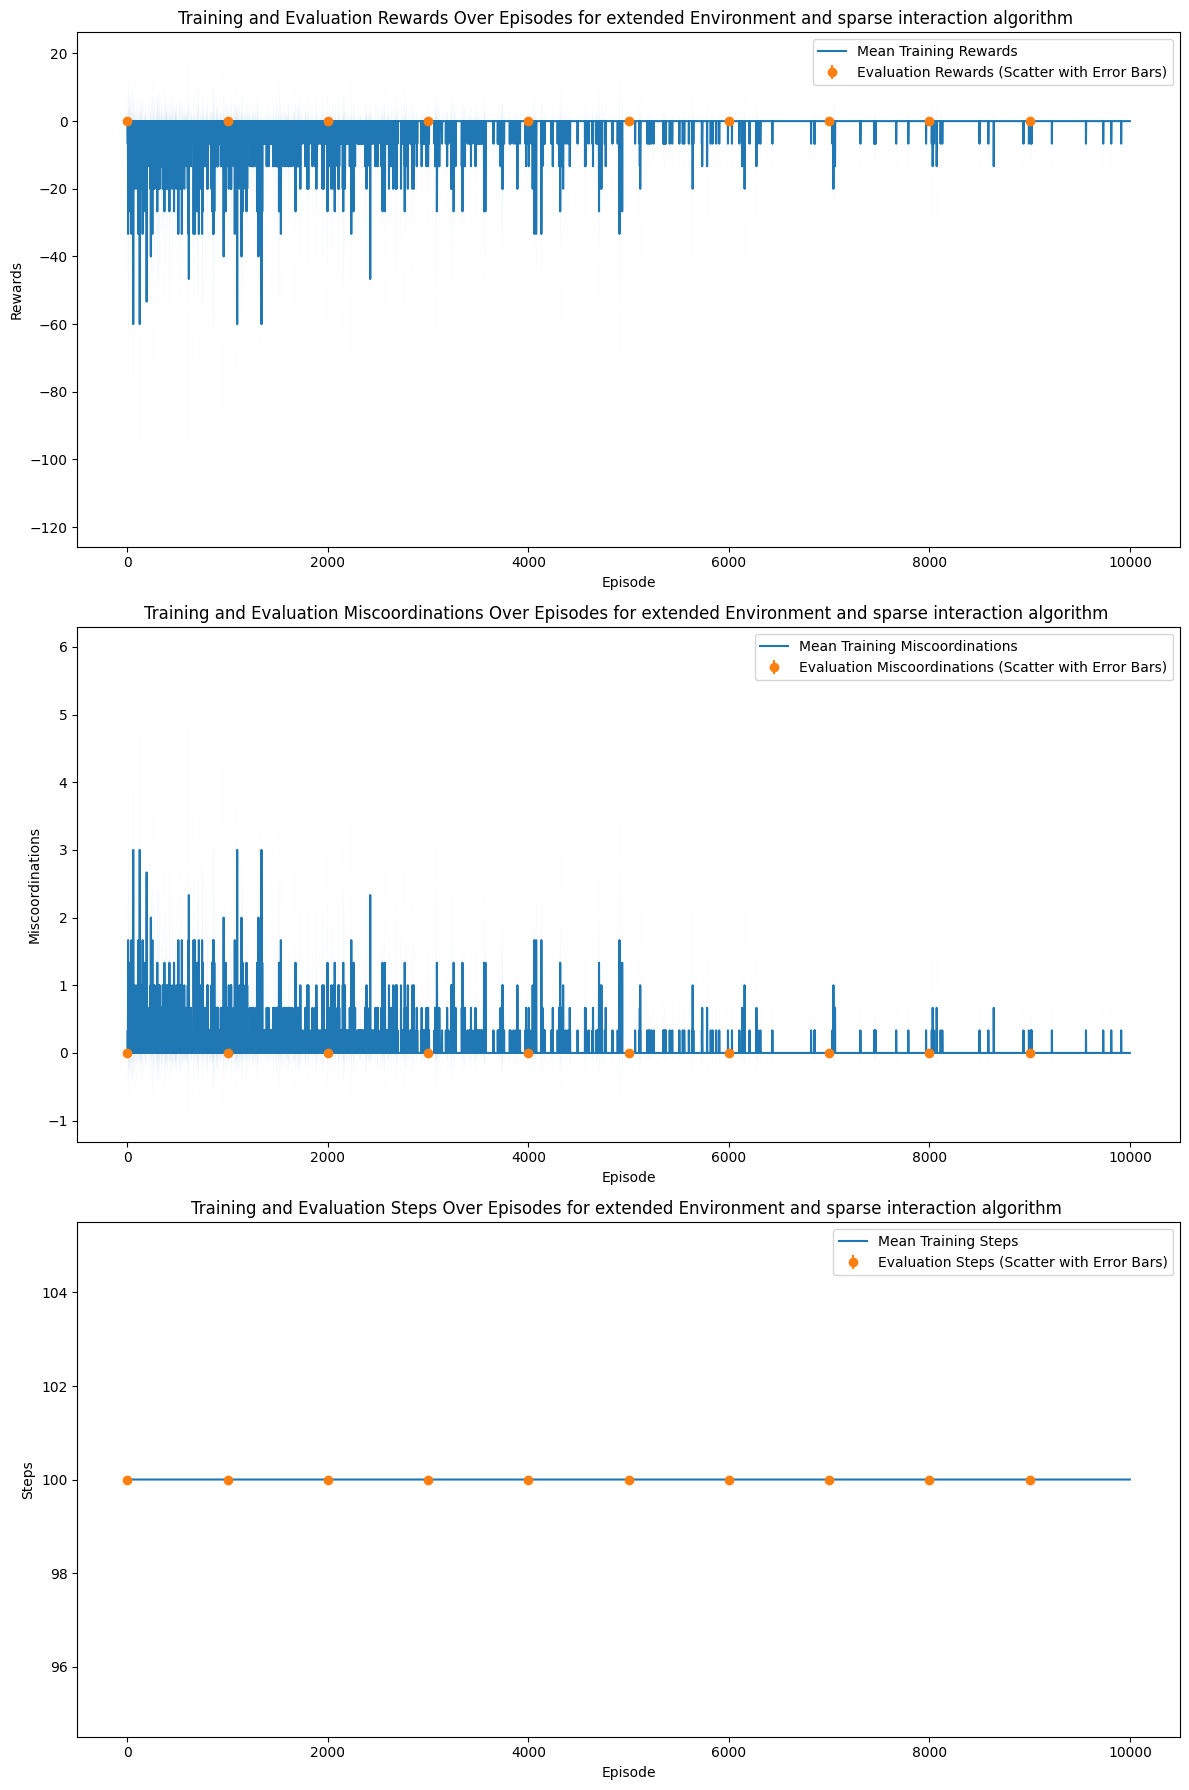

In [66]:
# --------------------------------------Cell 16---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "extended", "sparse interaction algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------

In [67]:
# -------------------------------- -----Cell 17---------------------------------------------------
# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Start -------------------------------------------------------

num_runs = 3
num_episodes = 10000
eval_interval = 1000
env_type = "four_robot"

training_results, evaluation_results = run_simulation2(num_runs, num_episodes, eval_interval, env_type)

# ----------------------- Main simulation loop for basic environment ---------------------------------
# ---------------------------------------Finish -------------------------------------------------------

Runs: 100%|██████████████████████████████████████████████████████████| 3/3 [39:33<00:00, 791.22s/it]


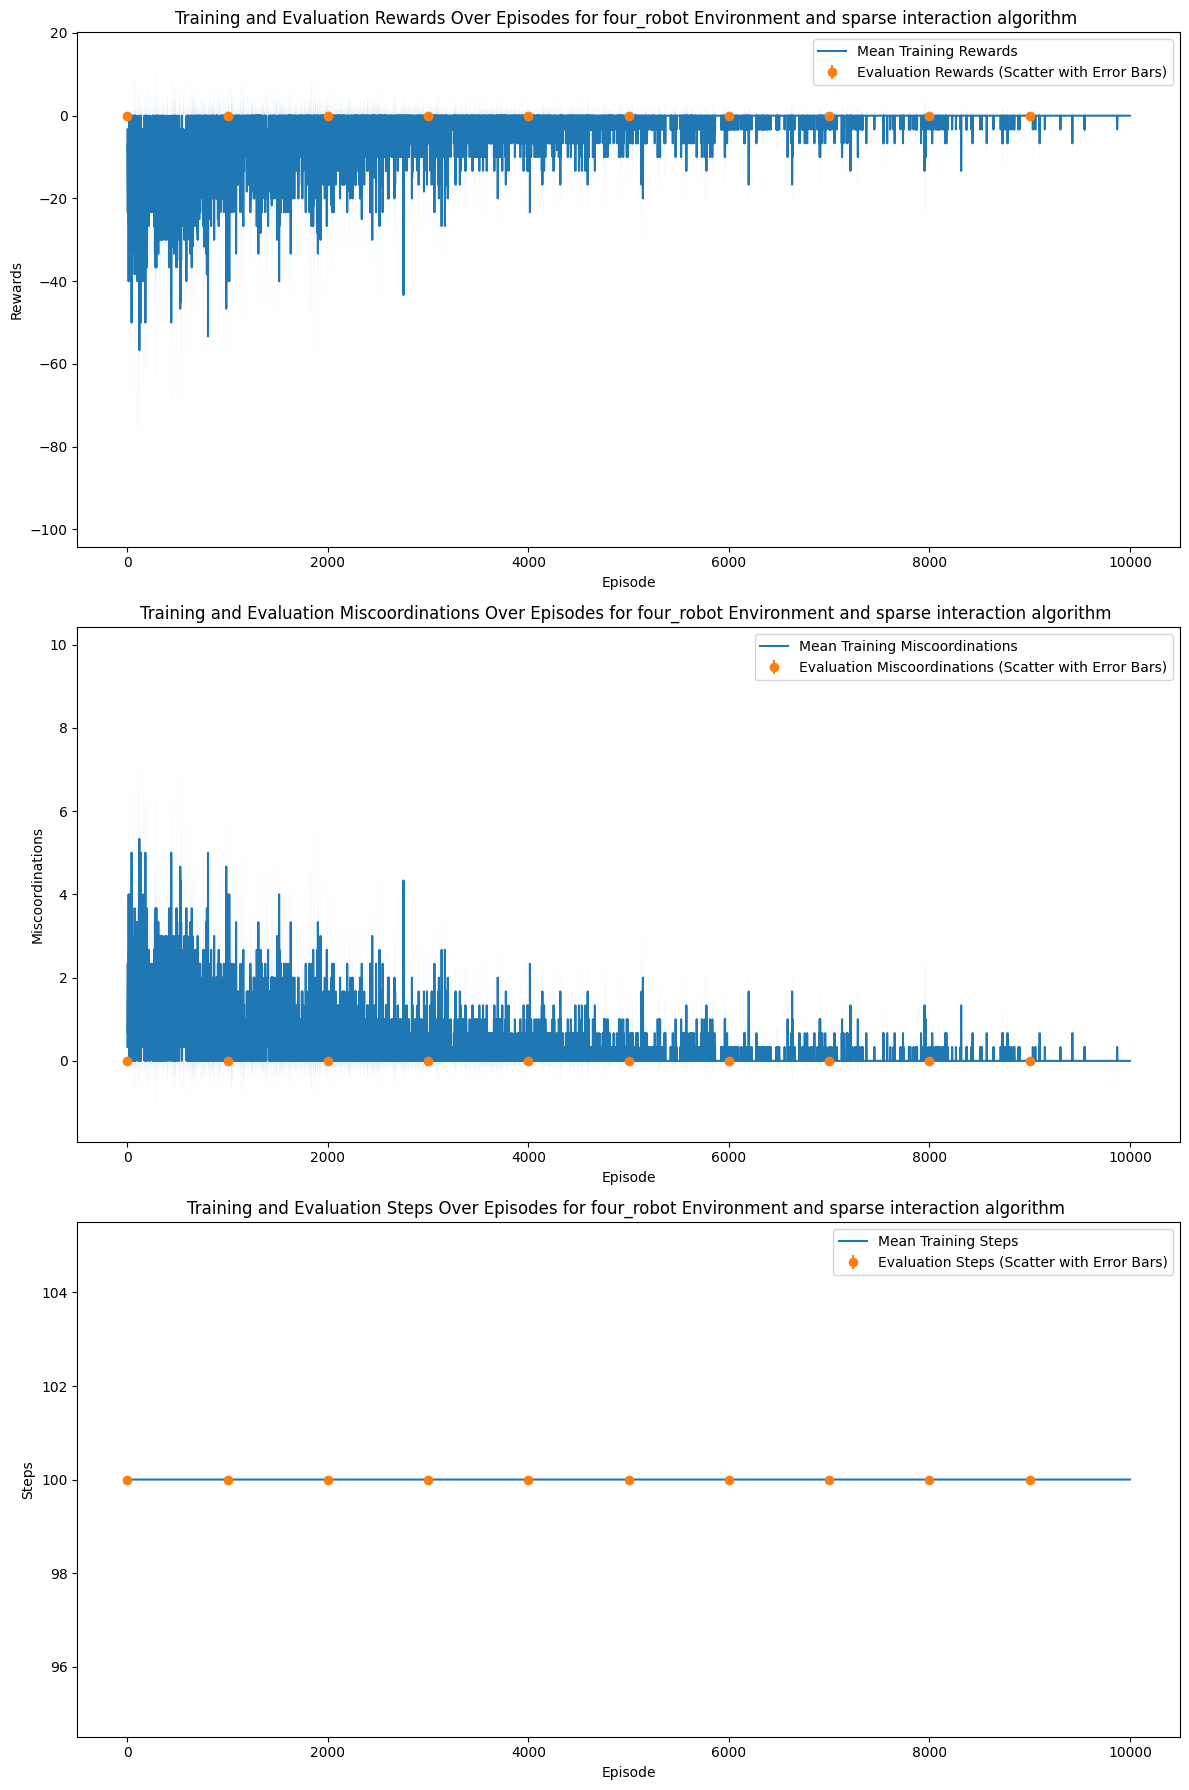

In [68]:
# --------------------------------------Cell 18---------------------------------------------------
# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Start -------------------------------------------------------

x_episodes = np.arange(num_episodes)
x_eval_episodes = np.arange(0, num_episodes, eval_interval)
plot_training_evaluation_results(training_results, evaluation_results, x_episodes, x_eval_episodes, "four_robot", "sparse interaction algorithm ")


# ------------------------------------- Plotting ---------------------------------------------
# ---------------------------------------Finish -------------------------------------------------------